# Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Helper Functions

`grayscale()`applies the Grayscale transform and returns an image with only one color channel.  
`canny()` applies the Canny transform.  
`gaussian_blur()` applies a Gaussian Noise kernel.  
`region_of_interest()` applies an image mask.  
`hough_lines()` returns an image with hough lines drawn.  
`draw_lines()` draws an array of line segments on a blank image.  
`slope_thresholding()` divides raw line segments into left and right lane.  
`weighted_img()` combines two images into a single image.  
`draw_lanes()` averages multiple raw lane lines into final lane segments.

In [118]:
import math

def grayscale(img):
    """NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = draw_lines(img, lines, [255, 0, 0], 2);
    
    return line_img, lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Draw an array of line segments on a blank image
    """
    line_img=np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8);
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img

def slope_thresholding(img,lines):
    """
    This function isolates somewhat vertical line segments.
    Then, it divides raw line segments into left and right lane.
    
    Input: 
    img= Color image from dashcam
    lines= Set of line segments which denote parts of lane lines
    """
    lane_raw=[];
    #Ignore segments which are somewhat horizantal
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            m=(y2-y1)/(x2-x1)
            if m>.25 or m<-.25:
                lane_raw.append(pts)
    
    #Separate left and right lanes
    left_lane_raw=[];
    right_lane_raw=[];
    for pts in lane_raw:
        for x1,y1,x2,y2 in pts:
            slope=((y2-y1)/(x2-x1));
            if slope<0:
                left_lane_raw.append(pts)
            else:
                right_lane_raw.append(pts)
                
    left_raw_img = draw_lines(img, left_lane_raw, [0, 255, 0], 2)
    right_raw_img = draw_lines(img, right_lane_raw, [0, 0, 255], 2)
    
    
    raw_lane_img = weighted_img(left_raw_img,right_raw_img,1,1,0)
    return raw_lane_img, left_lane_raw, right_lane_raw
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def draw_lanes(img, left_lane_raw, right_lane_raw):
    """
    This function plots left and right lane lines on dashcam image

    The raw lane lines are aggregated into single line segments denoting lane lines
    """
    
    #Find Top and Bottom x values of the lane
    #y_top=lines[0][0][1]
    #y_bottom=lines[0][0][1]
    #for pts in lines:
    #    for x1,y1,x2,y2 in pts:
    #        if y_top>y1:
    #            y_top=y1
    #        if y_bottom<y1:
    #            y_bottom=y1
    #        if y_top>y2:
    #            y_top=y2
    #        if y_bottom<y2:
    #            y_bottom=y2
    y_bottom=img.shape[0]
    y_top=.6*img.shape[0]

    #Calculate Left lane
    left_x,left_y,left_m,left_c=avg_line(left_lane_raw)
    left_lane=np.array([(y_top-left_c)/left_m,y_top,(y_bottom-left_c)/left_m,y_bottom]);
    left_lane=left_lane.astype(int)

    #Calculate Right lane
    right_x,right_y,right_m,right_c=avg_line(right_lane_raw)
    right_lane=np.array([(y_top-right_c)/right_m,y_top,(y_bottom-right_c)/right_m,y_bottom]);
    right_lane=right_lane.astype(int)
    
    lane=[[left_lane] , [right_lane]]
    if left_lane[0]>10000 or left_lane[0]<0 or right_lane[0]>10000 or right_lane[0]<0:
        return draw_lines(img, []); 
    
    lane_img=draw_lines(img, lane);    
    return lane_img

def avg_line(lines):
    avg_pt=np.array([0,0])
    slope_arr=np.array([]);
    for pts in lines:
        for x1,y1,x2,y2 in pts:
            m=(y2-y1)/(x2-x1)
            slope_arr=np.append(slope_arr,m)
            avg_pt=avg_pt+[(x1+x2)/2.0,(y1+y2)/2.0]
    slope=np.median(slope_arr)
    avg_pt=avg_pt/len(slope_arr)
    x=avg_pt[0]
    y=avg_pt[1]
    intercept= y-slope*x
    
    #print (x,y,slope,intercept)
    return x,y,slope,intercept
    

# Combine each image processing step as a Detailed image

`detailImg()` combines images from each image processing step. This helps in visualizing how the pipeline works and develop an intution on hyper-parameter selection.

In [3]:
def detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9):

    #Combile all images and show results
    ht=Img1.shape[0]
    wd=Img1.shape[1]
    DetailImg=np.zeros((3*ht, 3*wd, 3), dtype=np.uint8);
    DetailImg[:ht,:wd]=Img1;
    DetailImg[:ht,wd:2*wd]=cv2.merge((Img2,Img2,Img2));
    DetailImg[:ht,2*wd:3*wd]=cv2.merge((Img3,Img3,Img3));
    DetailImg[ht:2*ht,:wd]=cv2.merge((Img4,Img4,Img4));
    DetailImg[ht:2*ht,wd:2*wd]=cv2.merge((Img5,Img5,Img5));
    DetailImg[ht:2*ht,2*wd:3*wd]=Img6;
    DetailImg[2*ht:3*ht,:wd]=Img7;
    DetailImg[2*ht:3*ht,wd:2*wd]=Img8;
    DetailImg[2*ht:3*ht,2*wd:3*wd]=Img9;

    #Add titles for each step
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 2
    color = (255,255,255)
    thickness = 4
    linetype = cv2.LINE_AA
    w_off=10
    h_off=80
    cv2.putText(DetailImg, "1.Input", (w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "2.Grayscaling", (wd+w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "3.Blurring", (2*wd+w_off,h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "4.Edge Detection", (w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "5.Region Masking", (wd+w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "6.Hough Transform", (2*wd+w_off,ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "7.Slope Thresholding", (w_off,2*ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "8.Line averaging", (wd+w_off,2*ht+h_off),font,scale,color,thickness,linetype)
    cv2.putText(DetailImg, "9.Final Visualization", (2*wd+w_off,2*ht+h_off),font,scale,color,thickness,linetype)


    #Create grid seperators
    cv2.line(DetailImg, (wd, 0), (wd, 3*ht), [255,255,255], 2)
    cv2.line(DetailImg, (2*wd, 0), (2*wd, 3*ht), [255,255,255], 2)
    cv2.line(DetailImg, (0, ht), (3*wd, ht), [255,255,255], 2)
    cv2.line(DetailImg, (0, 2*ht), (3*wd, 2*ht), [255,255,255], 2)
    
    return DetailImg

# Image Processing Pipeline

`pipeline()` is the main function which unifies all the function calls to detect lane lines from an input image.

In [4]:
Hyperparam={'blur_kernel_size':5,
            'canny_low':50,
            'canny_high':150,
            'hough_rho':2,
            'hough_theta':np.pi/90,
            'hough_threshold':40,
            'hough_min_line_len':30,
            'hough_max_line_gap':20,};

def pipeline(Img, hyper):
    #STEP 1- INPUT
    Img1=Img

    #STEP 2- Grayscaling
    Img2=grayscale(Img1)

    #STEP 3- Blurring
    Img3=gaussian_blur(Img2, hyper['blur_kernel_size'])

    #STEP 4- Edge detection
    Img4=canny(Img3, hyper['canny_low'], hyper['canny_high'])

    #STEP 5- Region Masking
    Low_Lf=[.05*Img1.shape[1],Img1.shape[0]]
    Up_Lf=[.45*Img1.shape[1],.6*Img1.shape[0]]
    Up_Rt=[.55*Img1.shape[1],.6*Img1.shape[0]]
    Low_Rt=[.95*Img1.shape[1],Img1.shape[0]]
    poly=np.array([[Low_Lf,Up_Lf,Up_Rt,Low_Rt]], dtype=np.int32)
    Img5=region_of_interest(Img4, poly)

    #STEP 6- Hough Transform
    #Detecting line segments from edge pixels and creating blank image with lane lines
    (Img6,lines)=hough_lines(Img5, hyper['hough_rho'], hyper['hough_theta'], hyper['hough_threshold'], 
                             hyper['hough_min_line_len'], hyper['hough_max_line_gap'])

    #STEP 7- Slope Thresholding
    (Img7,left_raw,right_raw)=slope_thresholding(Img6,lines)

    #STEP 8- Averaging Raw lines
    Img8=draw_lanes(Img7,left_raw,right_raw)
    
    #STEP 9- Final Visualization
    #Superimposing lanes on original image
    Img9=weighted_img(Img8, Img1)
    
    #Generate Detail Image
    Img10=detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9)
    return Img9, Img10
    

# Import a single Image and run the image processing pipeline

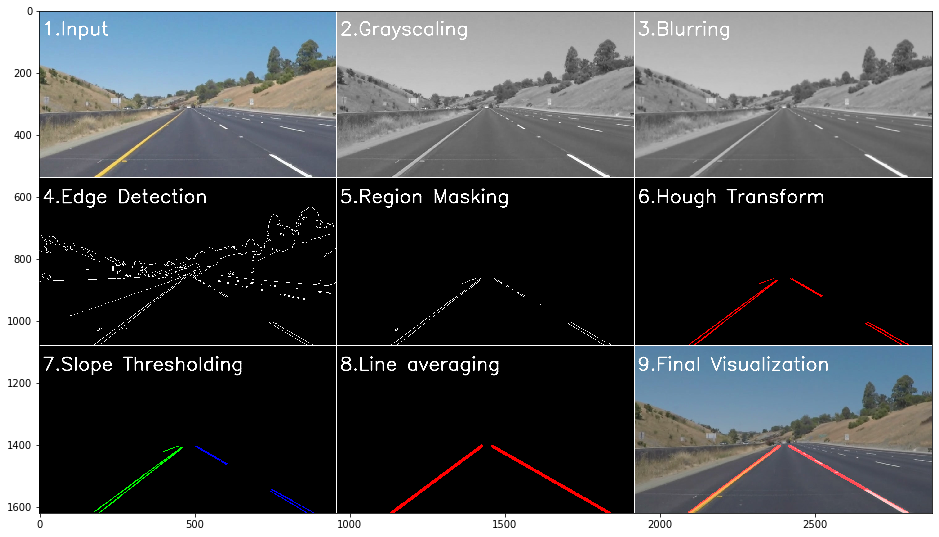

In [120]:
Inp = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
FinalImg,DetailImg=pipeline(Inp,Hyperparam)
cv2.imwrite("test_images_output/whiteCarLaneSwitch.jpg",cv2.cvtColor(FinalImg, cv2.COLOR_RGB2BGR))

#Print the Detail Image
fig1 = plt.figure(figsize = (16,16))
ax1 = fig1.add_subplot(111)
ax1.imshow(DetailImg)
plt.show()

# Import multiple Images and run the image processing pipeline

In [6]:
import os
images=os.listdir("test_images/")

for name in images:
    print(name)
    Inp = mpimg.imread('test_images/'+name)
    detName=name[0:-4]+"_detail.jpg"
    FinalImg,DetailImg=pipeline(Inp,Hyperparam)
    cv2.imwrite("test_images_output/"+name,cv2.cvtColor(FinalImg, cv2.COLOR_RGB2BGR))
    cv2.imwrite("test_images_output/"+detName,cv2.cvtColor(DetailImg, cv2.COLOR_RGB2BGR))

solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


# Interactive Image Processing Hyper-parameters tweaking
Optimum image processing hyper-parameters have been calculated emperically in this project. This interactive environment can be used to analyse the effect of each parameter on final lane detection.

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact_manual
def pipelineParam(blur_kernel=widgets.IntSlider(min=1,max=17,step=2,value=5),
                  canny_low=widgets.IntSlider(min=0,max=255,step=1,value=50),
                  canny_high=widgets.IntSlider(min=0,max=255,step=1,value=150),
                  hough_rho=widgets.IntSlider(min=1,max=10,step=1,value=2),
                  hough_theta=widgets.FloatSlider(min=np.pi/90,max=np.pi,step=.1,value=np.pi/90),
                  hough_thresh=widgets.IntSlider(min=1,max=100,step=1,value=40),
                  hough_mnlen=widgets.IntSlider(min=1,max=50,step=1,value=30),
                  hough_mxgp=widgets.IntSlider(min=1,max=50,step=1,value=20),
                 ):
    HyperparamInteract={'blur_kernel_size':blur_kernel,
                'canny_low':canny_low,
                'canny_high':canny_high,
                'hough_rho':hough_rho,
                'hough_theta':hough_theta,
                'hough_threshold':hough_thresh,
                'hough_min_line_len':hough_mnlen,
                'hough_max_line_gap':hough_mxgp,};
    
    Inp = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    FinalImg,DetailImg=pipeline(Inp,HyperparamInteract)
    #Print the Detail Image
    fig1 = plt.figure(figsize = (16,16))
    ax1 = fig1.add_subplot(111)
    ax1.imshow(DetailImg)
    plt.show()
    


interactive(children=(IntSlider(value=5, description='blur_kernel', max=17, min=1, step=2), IntSlider(value=50…

# Algorithm's execution time analysis

In this section we analyze the time being taken by each step in our algorithm. The execution time has been estimated using `timeit` module. It repeatedly runs a function and determines the mean and deviation of run-time. The execution time of each step in the above algorithm is

|Process                 |Execution Time (ms)|
|------------------------|-------------------|
|Importing Image         |17.7               |
|Resizing Image          |0.8                |
|Grayscaling             |0.3                |
|Blurring                |0.3                |
|Edge detection          |1.3                |
|Region Masking          |0.1                |
|Hough Transform         |1.3                |
|Slope Thresholding      |2.6                |
|Line Averaging          |0.6                |
|Final Image creation    |1.3                |
|Detail Image creation   |14.4               |


As can be observed by the table, processing one image takes a total of **40.7ms**. However, almost **80%** of execution time is taken by the first and last step. Thus, for an efficient real-time video-processing pipeline, the focus needs to be on improving the steps of importing and visualizing data.

Assuming a camera can capture video at 60 frames per second(fps), the time between each frame will be **16ms**. The execution time of the image processing pipeline has to be lesser than 16ms for our algorithm to process such a video. Excluding the importing and visualization steps, our pipeline takes **8.6ms** which satisfies this criterion. 

In [200]:
%timeit mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
%timeit cv2.cvtColor(cv2.imread('test_images/whiteCarLaneSwitch.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

18.3 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.7 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`cv2` library seems to be a bit better than `mpimg` library at importing images.

800 µs ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
346 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
293 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.31 ms ± 5.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
57.6 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.3 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.6 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
641 µs ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.28 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
14.4 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


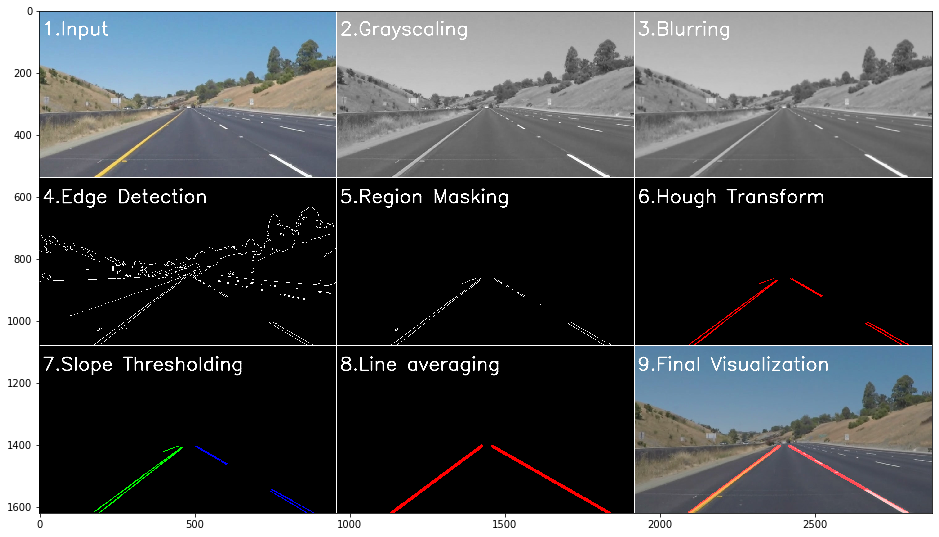

In [199]:
import time
Hyperparam={'blur_kernel_size':5,
            'canny_low':50,
            'canny_high':150,
            'hough_rho':2,
            'hough_theta':np.pi/90,
            'hough_threshold':40,
            'hough_min_line_len':30,
            'hough_max_line_gap':20,};

def pipelineBenchmark(Img, hyper):
    #STEP 1- INPUT
    scale=1;
    Img1=cv2.resize(Img,(0,0), fx=scale, fy=scale)
    %timeit cv2.resize(Img,(0,0), fx=scale, fy=scale)

    #STEP 2- Grayscaling
    Img2=grayscale(Img1)
    %timeit grayscale(Img1)

    #STEP 3- Blurring
    Img3=gaussian_blur(Img2, hyper['blur_kernel_size'])
    %timeit gaussian_blur(Img2, hyper['blur_kernel_size'])

    #STEP 4- Edge detection
    Img4=canny(Img3, hyper['canny_low'], hyper['canny_high'])
    %timeit canny(Img3, hyper['canny_low'], hyper['canny_high'])

    #STEP 5- Region Masking
    Low_Lf=[.05*Img1.shape[1],Img1.shape[0]]
    Up_Lf=[.45*Img1.shape[1],.6*Img1.shape[0]]
    Up_Rt=[.55*Img1.shape[1],.6*Img1.shape[0]]
    Low_Rt=[.95*Img1.shape[1],Img1.shape[0]]
    poly=np.array([[Low_Lf,Up_Lf,Up_Rt,Low_Rt]], dtype=np.int32)
    Img5=region_of_interest(Img4, poly)
    %timeit region_of_interest(Img4, poly)

    #STEP 6- Hough Transform
    #Detecting line segments from edge pixels and creating blank image with lane lines
    (Img6,lines)=hough_lines(Img5, hyper['hough_rho'], hyper['hough_theta'], hyper['hough_threshold'], 
                             hyper['hough_min_line_len'], hyper['hough_max_line_gap'])
    %timeit hough_lines(Img5, hyper['hough_rho'], hyper['hough_theta'], hyper['hough_threshold'],hyper['hough_min_line_len'], hyper['hough_max_line_gap'])

    #STEP 7- Slope Thresholding
    (Img7,left_raw,right_raw)=slope_thresholding(Img6,lines)
    %timeit slope_thresholding(Img6,lines)

    #STEP 8- Averaging Raw lines
    Img8=draw_lanes(Img7,left_raw,right_raw)
    %timeit draw_lanes(Img7,left_raw,right_raw)
    
    #STEP 9- Final Visualization
    #Superimposing lanes on original image
    Img9=weighted_img(Img8, Img1)
    %timeit weighted_img(Img8, Img1)
    
    #Generate Detail Image
    Img10=detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9)
    %timeit detailImg(Img1, Img2, Img3, Img4, Img5, Img6, Img7, Img8, Img9)
    
    #TOTAL TARGET EXECUTION TIME-16ms
    
    return Img9, Img10
    

Inp = cv2.imread('test_images/whiteCarLaneSwitch.jpg', cv2.IMREAD_UNCHANGED) 
Inp = cv2.cvtColor(Inp, cv2.COLOR_BGR2RGB)
FinalImg,DetailImg=pipelineBenchmark(Inp,Hyperparam)

#Print the Detail Image
fig1 = plt.figure(figsize = (16,16))
ax1 = fig1.add_subplot(111)
ax1.imshow(DetailImg)
plt.show()

In [195]:
%timeit pipeline(Inp,Hyperparam)

24.6 ms ± 455 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
